# Homework 2: Multiple Layer Perceptron

## 1. Performance vs. Width

In this exercise, we will experiment with the number of hidden units in a multilayer perceptron (MLP) with a single hidden layer. The number of hidden units is also referred to the width of the hidden layer.

Here are the details:
- The setup is identical to the demo/lab and you may reuse that code. Take the FashionMNIST dataset and randomly subsample 12% of its training set to work with. As a test set, we will use the full test set of FashionMNIST.
- Define a MLP with one hidden layer of width h = 16. Find the divergent learning rate η∗ for this model and use a fixed learning rate of η∗/2, as we discussed in class.
- Train the model for 120 passes over the data.
- Repeat this procedure for widths h = 8, 32, 128, 512 with the same learning rate η∗/2 as above (i.e., you do not need to find the divergent learning rate of each model for this exercise).


In [1]:
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time

import matplotlib.pyplot as plt 
%matplotlib inline 

# Fix the random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(1)

### 1.1 Loading the MNIST dataset

We load the MNIST dataset and set up some helper functions to preprocess the data

In [2]:
# download dataset (~117M in size)
train_dataset = FashionMNIST('../../data', train=True, download=False)
X_train = train_dataset.data # torch tensor of type uint8 of shape (n, 28, 28)
y_train = train_dataset.targets.long() # torch tensor of type Long of shape (n,)
test_dataset = FashionMNIST('../../data', train=False, download=False)
X_test = test_dataset.data
y_test = test_dataset.targets.long()

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=int(X_train.shape[0]*0.12)))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
idxs_test = torch.from_numpy(
    np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]))
X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([7200, 28, 28])
n_train: 7200, n_test: 10000
Image size: torch.Size([28, 28])


One Row of Pixels: tensor([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0, 69, 98,  0, 95, 37,  0,
         0,  1,  1,  0,  0,  0,  0,  0,  0,  0], dtype=torch.uint8)


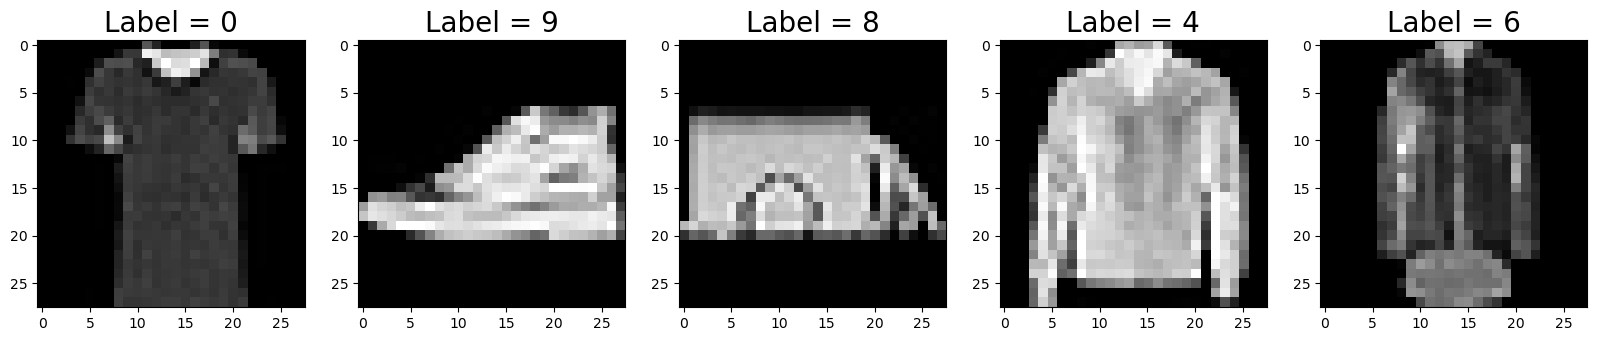

In [3]:
f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
# Each number represents the grayscale intensity [0, 255]
print("One Row of Pixels:", X_train[0][0])

Let us normalize the data and define some utility functions. We start by flattening the $28 \times 28$ image into a vector of size $784$.

In [4]:
print("Original Shape:", X_train.shape)
X_train = X_train.float()  # convert to float32. Shape: (n, 28, 28)
X_train = X_train.view(-1, 784)  # Shape: (n, 784)
print("Flatten Shape:", X_train.shape)
mean, std = X_train.mean(axis=0), X_train.std(axis=0)  # Shape: (784,)

Original Shape: torch.Size([7200, 28, 28])
Flatten Shape: torch.Size([7200, 784])


In [5]:
# Normalize dataset: pixel values lie between 0 and 255
# Normalize them so the pixelwise mean is zero and standard deviation is 1
# Normalize: add a small number to avoid divide by zero
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6) # Shape: (n, 784)

X_test = X_test.float()  # Shape: (n', 28, 28)
X_test = X_test.view(-1, 784)  # Shape: (n', 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)  # Shape: (n', 784)

n_class = np.unique(y_train).shape[0]  # We have K=10 classes numbered (0, 1, ..., 9)
print("Number of Classes: ", n_class)


Number of Classes:  10


## 1.2 Setup Code for Multilayer Perceptron

In [6]:
# Some utility functions to compute the objective and the accuracy

def mlp(X, ws, bs):
    hidden = X # Shape: (n, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        # hidden = relu(W_(r<j)x + b_(r<j))
        hidden = torch.matmul(hidden, w) + b[None, :]  # Shape: (n, d_{j-1}) * (d_{j-1}, d_j) = (n, d_j)
        hidden = torch.nn.functional.relu(hidden)
    # return W_j(hidden)+ b_j
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :]

def compute_objective(ws, bs, X, y, reg_param):
    """ Compute the multinomial logistic loss. 
        ws is a list of tensors of consistent shapes,
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # Shape: (n, K)
    # PyTorch's function cross_entropy computes the multinomial logistic loss
    # Adding L2 penalization
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy(ws, bs, X, y):
    """ Compute the classification accuracy
        ws is a list of tensors of consistent shapes 
        X of shape (n, d) and y of shape (n,)
    """
    score = mlp(X, ws, bs)  # shape: (n, K`)
    predictions = torch.argmax(score, axis=1)  # class with highest score is predicted
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(ws, bs, reg_param, verbose=False):
    train_loss = compute_objective(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy(ws, bs, X_test, y_test)
    if verbose:
        print(('Train Loss = {:.3f}, Train Accuracy = {:.3f}, ' + 
               'Test Loss = {:.3f}, Test Accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(), 
                test_loss.item(), test_accuracy.item())
    )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

Let us again write the analogous function to make a pass of SGD.

In [7]:
def sgd_one_pass(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        # compute the objective. 
        # Note: This function requires X to be of shape (n,d). In this case, n=1 
        objective = compute_objective(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param)
  
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
        
        # compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # perform SGD update. IMPORTANT: Make the update inplace!
        with torch.no_grad():
            for (var, g) in zip(all_parameters, gradients):
                var -= learning_rate * g
    return ws, bs

### Finding divergent learning rate

Next, we find the divergence learning rate. The procedure to find the divergent learning is the same as previously.

The one difference, however, is that *initializing the weights at zero will no longer work*.
This is because the gradient at $w = 0$ is exactly zero. (Exercise: work this out!)

For now, we shall initialize the weights randomly with a small weight. We shall come back to how to initialize the weights.

In [8]:
# Try .1 .01 .005
learning_rate = 0.005
reg_param = 0.0

hidden_size = 16 # Specifying hidden layer size as required by the assignment
ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)


ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)


Train Loss = 2.303, Train Accuracy = 0.083, Test Loss = 2.303, Test Accuracy = 0.081
1.4593142600905884
1.9949142218871925
2.188067020354505
2.2588099879561176
2.290611946372038
2.29784252850576
2.298251459628843
2.3022689114689694
2.3013212246555512
2.3013366243676185
2.273641095309765
2.2023990619780016
2.1052251461814793
1.9964394992101289
1.8113888867909969
1.7110635497795577
1.5537666915471835
1.515839637021591
1.4008447646453017
1.3048771435893178
1.2129712166297217
1.208677220414481
1.1924148641706331
1.109098700237786
1.046789134773034
1.0422357532297868
1.0553602352584353
1.0166973874568466
0.9415350292287106
0.8873618077357698
0.8667913225738217
0.8574689866704245
0.9122643184625764
0.9592756108671847
0.8002219425188856
0.7543871703638302
0.7015963619207822
0.6940636688420437
0.7570049385452527
0.6979633008625136
0.7850056933312417
0.731782277495419
0.7702286937201989
0.6414480255687051
0.7308996819251501
0.7082830437137063
0.6955889525400134
0.6384277574972598
0.688037411492

In [9]:
divergent_learning_rate = 5e-3

def train_model(learning_rate=divergent_learning_rate, hidden_size=16):

      logs = []

      ws = [1e-6 * torch.randn(784, hidden_size, requires_grad=True),
            1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
      bs = [torch.zeros(hidden_size, requires_grad=True),
            torch.zeros(n_class, requires_grad=True)]
      logs.append(compute_logs(ws, bs, reg_param, verbose=True))

      for j in range(10):
            print(j+1, end=', ')
            ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
            logs.append(compute_logs(ws, bs, reg_param, verbose=True))

      logs = np.asarray(logs)

      f, ax = plt.subplots(1, 2, figsize=(10, 4))
      ax[0].plot(logs[:, 0], label='Train')
      ax[0].plot(logs[:, 2], label='Test')
      ax[0].set_title('Loss', fontsize=18)
      ax[0].set_xlabel('#Passes', fontsize=18)

      ax[1].plot(logs[:, 1], label='Train')
      ax[1].plot(logs[:, 3], label='Test')
      ax[1].set_title('Accuracy', fontsize=18)
      ax[1].set_xlabel('#Passes', fontsize=18)

      ax[0].legend(fontsize=18)


Train Loss = 2.303, Train Accuracy = 0.098, Test Loss = 2.303, Test Accuracy = 0.096
1, Train Loss = 0.566, Train Accuracy = 0.799, Test Loss = 0.625, Test Accuracy = 0.775
2, Train Loss = 0.436, Train Accuracy = 0.844, Test Loss = 0.551, Test Accuracy = 0.814
3, Train Loss = 0.450, Train Accuracy = 0.834, Test Loss = 0.595, Test Accuracy = 0.796
4, Train Loss = 0.369, Train Accuracy = 0.869, Test Loss = 0.569, Test Accuracy = 0.819
5, Train Loss = 0.334, Train Accuracy = 0.881, Test Loss = 0.571, Test Accuracy = 0.818
6, Train Loss = 0.339, Train Accuracy = 0.874, Test Loss = 0.581, Test Accuracy = 0.814
7, Train Loss = 0.345, Train Accuracy = 0.874, Test Loss = 0.610, Test Accuracy = 0.807
8, Train Loss = 0.285, Train Accuracy = 0.899, Test Loss = 0.579, Test Accuracy = 0.824
9, Train Loss = 0.328, Train Accuracy = 0.879, Test Loss = 0.655, Test Accuracy = 0.803
10, Train Loss = 0.272, Train Accuracy = 0.905, Test Loss = 0.656, Test Accuracy = 0.826


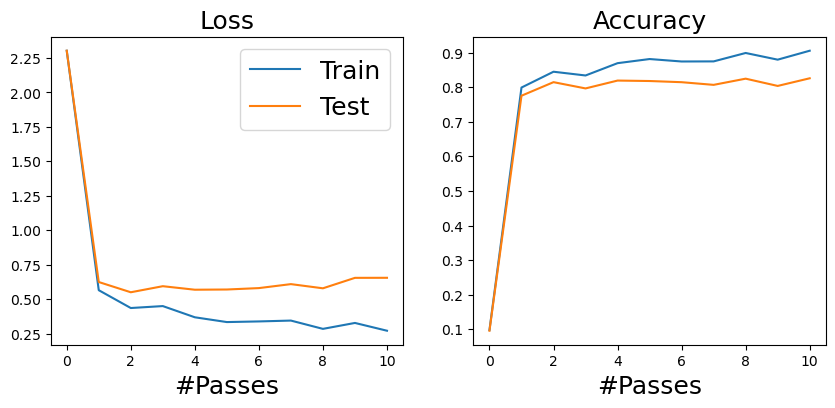

In [10]:
train_model()